In [1]:
# Analysis Tools
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import math

# Plotting Tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Extra Plotting Tools Required for Bar Chart Race
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

# Plot Design Settings
sns.set_style("darkgrid", {"axes.facecolor": "#eff2f5", 'grid.color': '#c0ccd8', 
                           'patch.edgecolor': '#B0B0B0', 'font.sans-serif': 'Verdana'})
sns.set_palette('Dark2_r')
plt.rc('font', size=19)
plt.rc('axes', titlesize=25)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=17)
plt.rc('ytick', labelsize=17)
plt.rc('figure', titlesize=24)

# Other Tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler        # For standardizing features

# Mute warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Base Data
df = pd.read_csv("data/linked_data.csv")

In [3]:
df = df.drop('Unnamed: 0', axis=1)

In [4]:
df.head(2)

Country e_type  Year   e_con  e_prod      GDP  Population  ei_capita  \
0   World    all  1988  345.56  347.41  42106.6  4927545.08      70.13   
1   World   coal  1988   96.87   98.48  42106.6  4927545.08      70.13   

   ei_gdp  pop_growth  pop_density  manuf_GDP  agri_GDP  Deforestation  \
0    8.21       2.858       15.229       12.8    10.507            NaN   
1    8.21       2.858       15.229       12.8    10.507            NaN   

   emission_per_cap  CO2_emission  
0          0.004295      21163.84  
1          0.001812       8930.92

The calculation of a country's GDP encompasses all private and public consumption, government outlays, investments, additions to private inventories, paid-in construction costs, and the foreign balance of trade. 

We will be focusing on Just the GDP Contributions of the Manufacturing & Agricultural Industries per country per time.

It's also worthy of Note that the `manuf_GDP & agri_GDP` are percentage contribution of the overal GDP, Hence we'll have to extract the value for computation.

In [5]:
df['Manuf_GDP'] = (df['manuf_GDP']/100)*df['GDP']
df['Agric_GDP'] = (df['agri_GDP']/100)*df['GDP']

In [6]:
df.head()

Country   e_type  Year   e_con  e_prod      GDP  Population  ei_capita  \
0   World      all  1988  345.56  347.41  42106.6  4927545.08      70.13   
1   World     coal  1988   96.87   98.48  42106.6  4927545.08      70.13   
2   World  nat_gas  1988   71.01   71.85  42106.6  4927545.08      70.13   
3   World  pet/oth  1988  133.45  132.49  42106.6  4927545.08      70.13   
4   World  nuclear  1988   19.23   19.23  42106.6  4927545.08      70.13   

   ei_gdp  pop_growth  pop_density  manuf_GDP  agri_GDP  Deforestation  \
0    8.21       2.858       15.229       12.8    10.507            NaN   
1    8.21       2.858       15.229       12.8    10.507            NaN   
2    8.21       2.858       15.229       12.8    10.507            NaN   
3    8.21       2.858       15.229       12.8    10.507            NaN   
4    8.21       2.858       15.229       12.8    10.507            NaN   

   emission_per_cap  CO2_emission  Manuf_GDP    Agric_GDP  
0          0.004295      21163.84  5389.6448  4424.140462  
1          0.001812       8930.92  5389.6448  4424.140462  
2          0.000725       3571.68  5389.6448  4424.140462  
3          0.001758       8661.24  5389.6448  4424.140462  
4          0.000000          0.00  5389.6448  4424.140462

In [7]:
"""
Let's Reposition our Target variable CO2 Emission at the End
"""
# Seperate Other Features From Target Variable
others = df.drop(['CO2_emission'], axis=1)
co = df['CO2_emission']
# concat both Tables 
df = pd.concat([others, co], axis=1)

<AxesSubplot:>

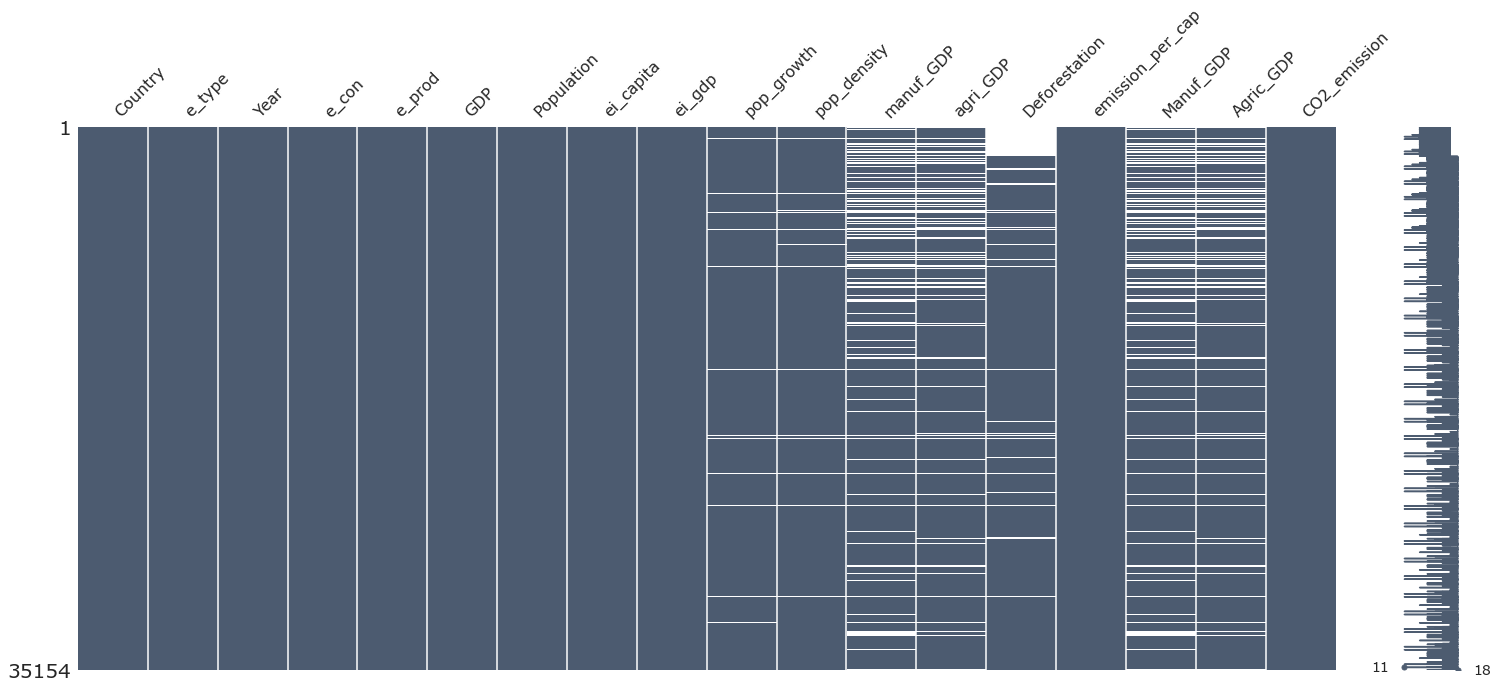

In [8]:
# Let's Visualize our missing values
import missingno as msno

msno.matrix(df, color=(0.3,0.36,0.44))

In [9]:
'''
As Temporary Defeat to dealing with our missing values
We Opted to dropping all rows with missing values

AS Base Analysis
'''

df.dropna(subset=['Deforestation', 'agri_GDP', 'manuf_GDP', 'pop_density', 'pop_growth'], inplace=True)

<AxesSubplot:>

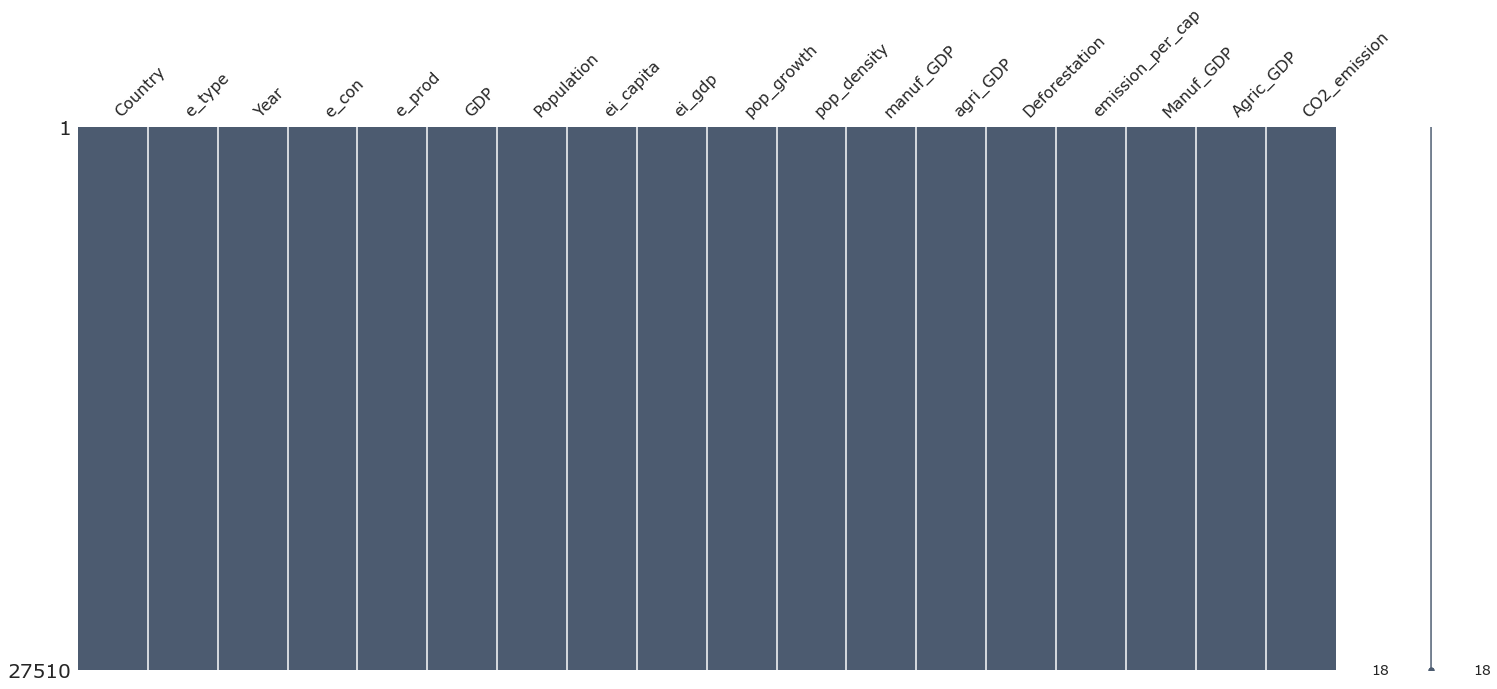

In [10]:
msno.matrix(df, color=(0.3,0.36,0.44))

So We've dropped from `35154` Observations to `27510`, which to a certain extent, representative for our base analysis

In [12]:
df = df.drop(['manuf_GDP', 'agri_GDP'], axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27510 entries, 1920 to 35153
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country           27510 non-null  object 
 1   e_type            27510 non-null  object 
 2   Year              27510 non-null  int64  
 3   e_con             27510 non-null  float64
 4   e_prod            27510 non-null  float64
 5   GDP               27510 non-null  float64
 6   Population        27510 non-null  float64
 7   ei_capita         27510 non-null  float64
 8   ei_gdp            27510 non-null  float64
 9   pop_growth        27510 non-null  float64
 10  pop_density       27510 non-null  float64
 11  Deforestation     27510 non-null  float64
 12  emission_per_cap  27510 non-null  float64
 13  Manuf_GDP         27510 non-null  float64
 14  Agric_GDP         27510 non-null  float64
 15  CO2_emission      27510 non-null  float64
dtypes: float64(13), int64(1), object(2)
m

In [14]:
round(df.describe())

Year    e_con   e_prod       GDP  Population  ei_capita   ei_gdp  \
count  27510.0  27510.0  27510.0   27510.0     27510.0    27510.0  27510.0   
mean    2005.0      2.0      2.0     987.0     77392.0       84.0      4.0   
std        8.0     18.0     18.0    7009.0    540498.0      117.0      4.0   
min     1990.0     -0.0      0.0       0.0        40.0        0.0      0.0   
25%     1998.0      0.0      0.0      14.0      2335.0       10.0      2.0   
50%     2006.0      0.0      0.0      55.0      7779.0       39.0      4.0   
75%     2013.0      0.0      0.0     291.0     23515.0      112.0      5.0   
max     2019.0    601.0    612.0  127690.0   7714631.0     1115.0    167.0   

       pop_growth  pop_density  Deforestation  emission_per_cap  Manuf_GDP  \
count     27510.0      27510.0        27510.0           27510.0    27510.0   
mean          2.0        179.0           33.0               0.0      138.0   
std           1.0        558.0           24.0               0.0      856.0   
min          -7.0          1.0            0.0              -0.0        0.0   
25%           1.0         28.0           12.0               0.0        1.0   
50%           1.0         71.0           32.0               0.0        7.0   
75%           2.0        146.0           52.0               0.0       44.0   
max          18.0       8045.0           99.0               0.0    14517.0   

       Agric_GDP  CO2_emission  
count    27510.0       27510.0  
mean        64.0         108.0  
std        474.0        1144.0  
min          0.0          -0.0  
25%          1.0           0.0  
50%          5.0           0.0  
75%         17.0           9.0  
max       6897.0       35585.0

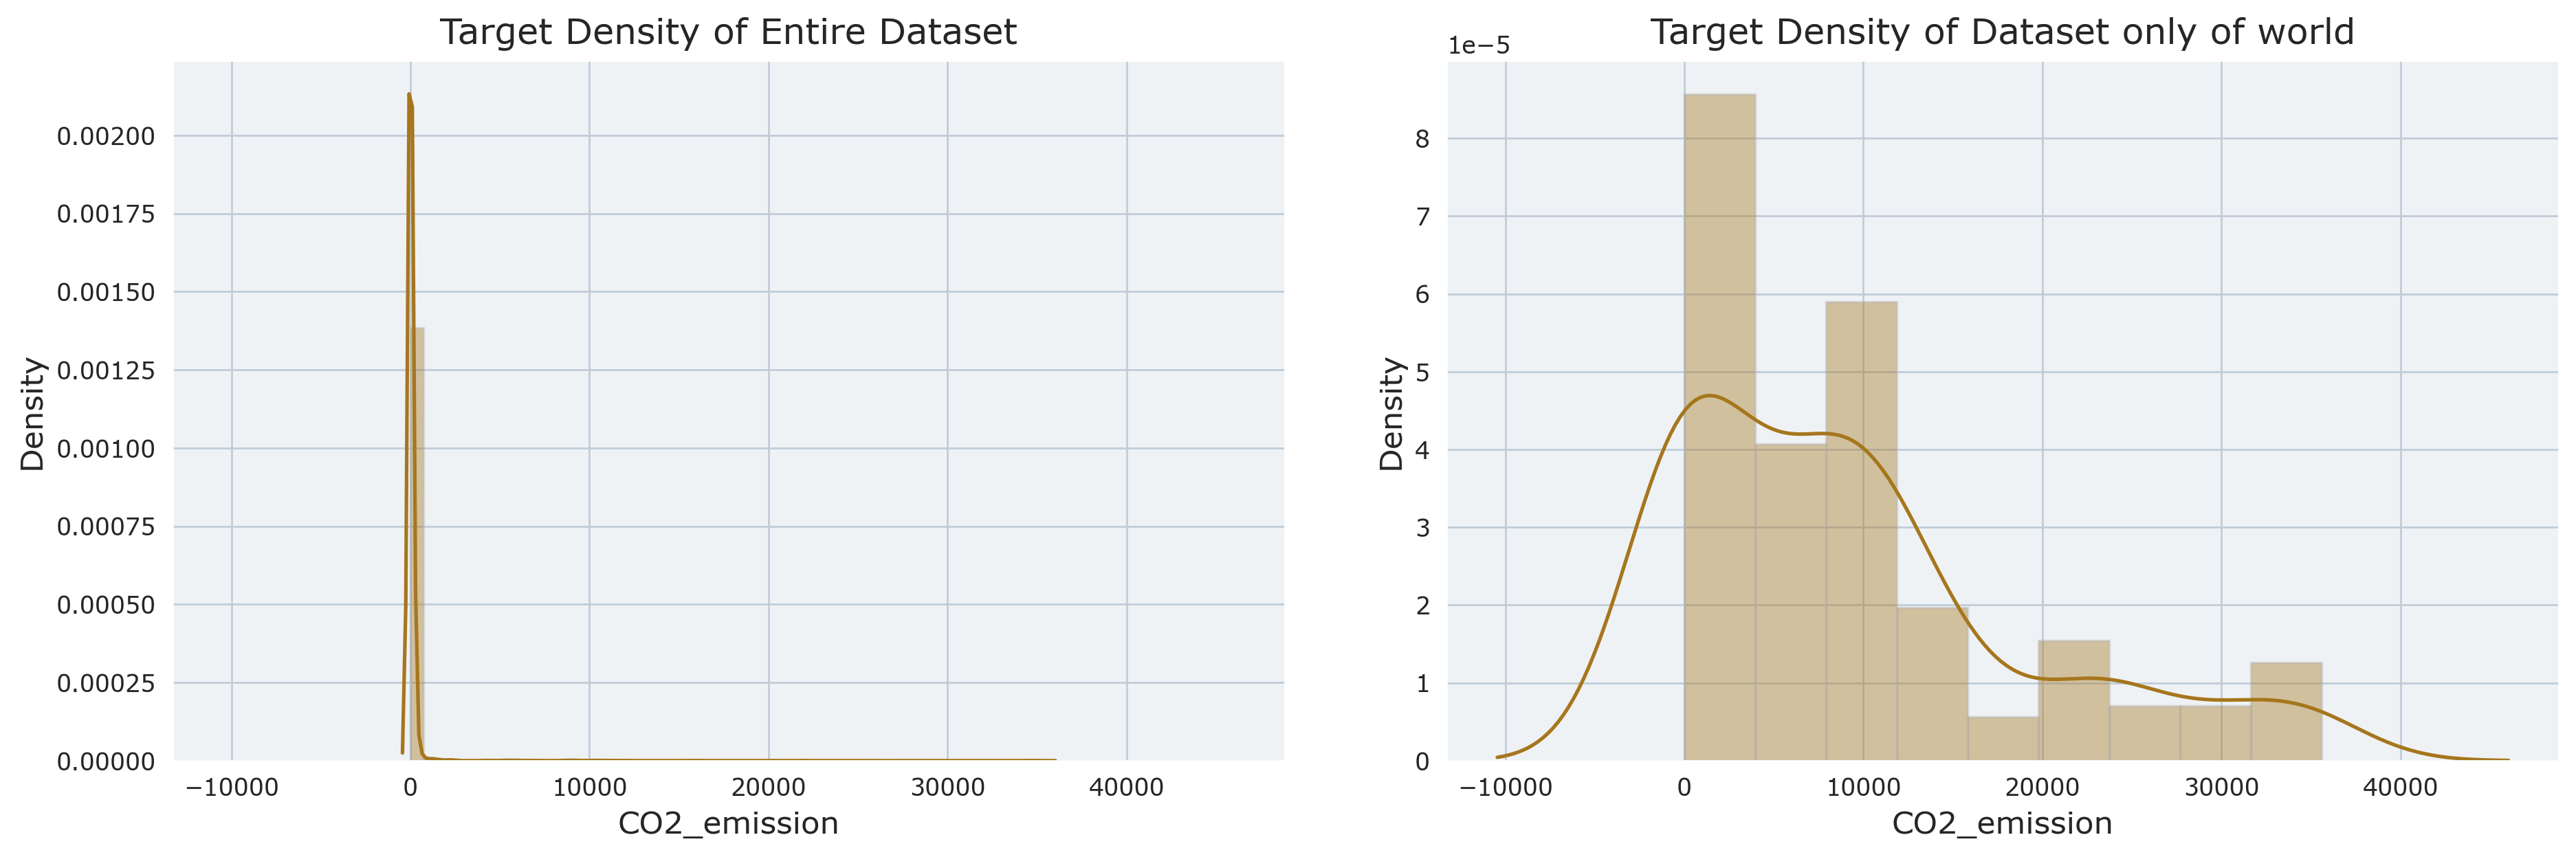

In [15]:
'''
Plotting Distplot to Reveal the univariate distribution of our Target data
'''
with plt.rc_context(rc = {'figure.dpi': 250, 'axes.labelsize': 13,
                          'xtick.labelsize': 10, 'ytick.labelsize': 10,
                          'legend.title_fontsize': 7, 'axes.titlesize': 15,
                          'axes.titlepad': 7}):


    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,5))
    
    # Entire dataset
    sns.distplot(df['CO2_emission'], ax=ax[0]).set_title('Target Density of Entire Dataset')
    
    # Dataset only for world
    world = df[df['Country']=='World']
    sns.distplot(world['CO2_emission'], ax=ax[1]).set_title('Target Density of Dataset only for world')

    plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
    plt.show()

Dataset remains representative of the raw energy data we got on Commencement after much cleaning up and fixing of missing records, and as we can see, our distribution is `Highly right skewed`.

Data is skewed when its distribution curve is asymmetrical (as compared to a normal distribution curve that is perfectly symmetrical) and the skewness for a normal distribution is 0. It degrades the model’s ability (especially regression based models) to describe typical cases as it has to deal with rare cases on extreme values, However, `tree based models` are immune to this.

In [28]:
# check for skew in data (Confirmation)
df.skew().sort_values(ascending=False)

e_prod              21.961017
e_con               21.674096
CO2_emission        20.099630
ei_gdp              16.175313
GDP                 12.790157
Agric_GDP           11.652741
Population          11.537407
Manuf_GDP           11.517337
pop_density         10.209514
emission_per_cap     5.102755
ei_capita            2.977128
pop_growth           1.893131
Deforestation        0.452278
Year                -0.112928
dtype: float64

The method used to transform the skewed data depends on the characteristics of the data.
We could apply one of the following options in a bit to normalize our dataset;

1. **log transformation:** transform skewed distribution to a normal distribution
2. **FInd & Remove outliers**
3. **Normalize (min-max)**
4. **Adopting TREE-Based Modelling** To avoid much distortion of original data

In [38]:
"""
Replace all Zero Values of emission with 0.1 due to logging
"""
# replace values of one DataFrame
# with the value of another DataFrame
df1 = df.copy()
df1 = df1.replace(0, 0.1)

In [46]:
# Log transform multiple columns in dataframe 
lf = df1[['e_con', "e_prod", 'GDP', 'Agric_GDP', 'ei_gdp',
        'Manuf_GDP', "Population", 'pop_density', 
         'pop_growth', "ei_capita", 'Deforestation',
        'emission_per_cap', "CO2_emission",]].apply(lambda x: np.log(x))

In [47]:
lf['Year'] = df['Year']
lf['Country'] = df['Country']
lf['e_type'] = df['e_type']

In [49]:
# Check.... Looking Good
lf.head()

e_con    e_prod        GDP  Agric_GDP    ei_gdp  Manuf_GDP  \
1920  5.867997  5.880086  10.804256   8.410652  1.971299   8.451535   
1921  4.562993  4.596230  10.804256   8.410652  1.971299   8.451535   
1922  4.319087  4.326910  10.804256   8.410652  1.971299   8.451535   
1923  4.913610  4.914124  10.804256   8.410652  1.971299   8.451535   
1924  3.013572  3.013572  10.804256   8.410652  1.971299   8.451535   

      Population  pop_density  pop_growth  ei_capita  Deforestation  \
1920   15.482132     2.786985    1.302369   4.201404       0.579978   
1921   15.482132     2.786985    1.302369   4.201404       0.579978   
1922   15.482132     2.786985    1.302369   4.201404       0.579978   
1923   15.482132     2.786985    1.302369   4.201404       0.579978   
1924   15.482132     2.786985    1.302369   4.201404       0.579978   

      emission_per_cap  CO2_emission  Year Country   e_type  
1920         -5.476150     10.005982  1990   World      all  
1921         -6.354275      9.127857  1990   World     coal  
1922         -7.206924      8.275208  1990   World  nat_gas  
1923         -6.374376      9.107756  1990   World  pet/oth  
1924         -2.302585     -2.302585  1990   World  nuclear

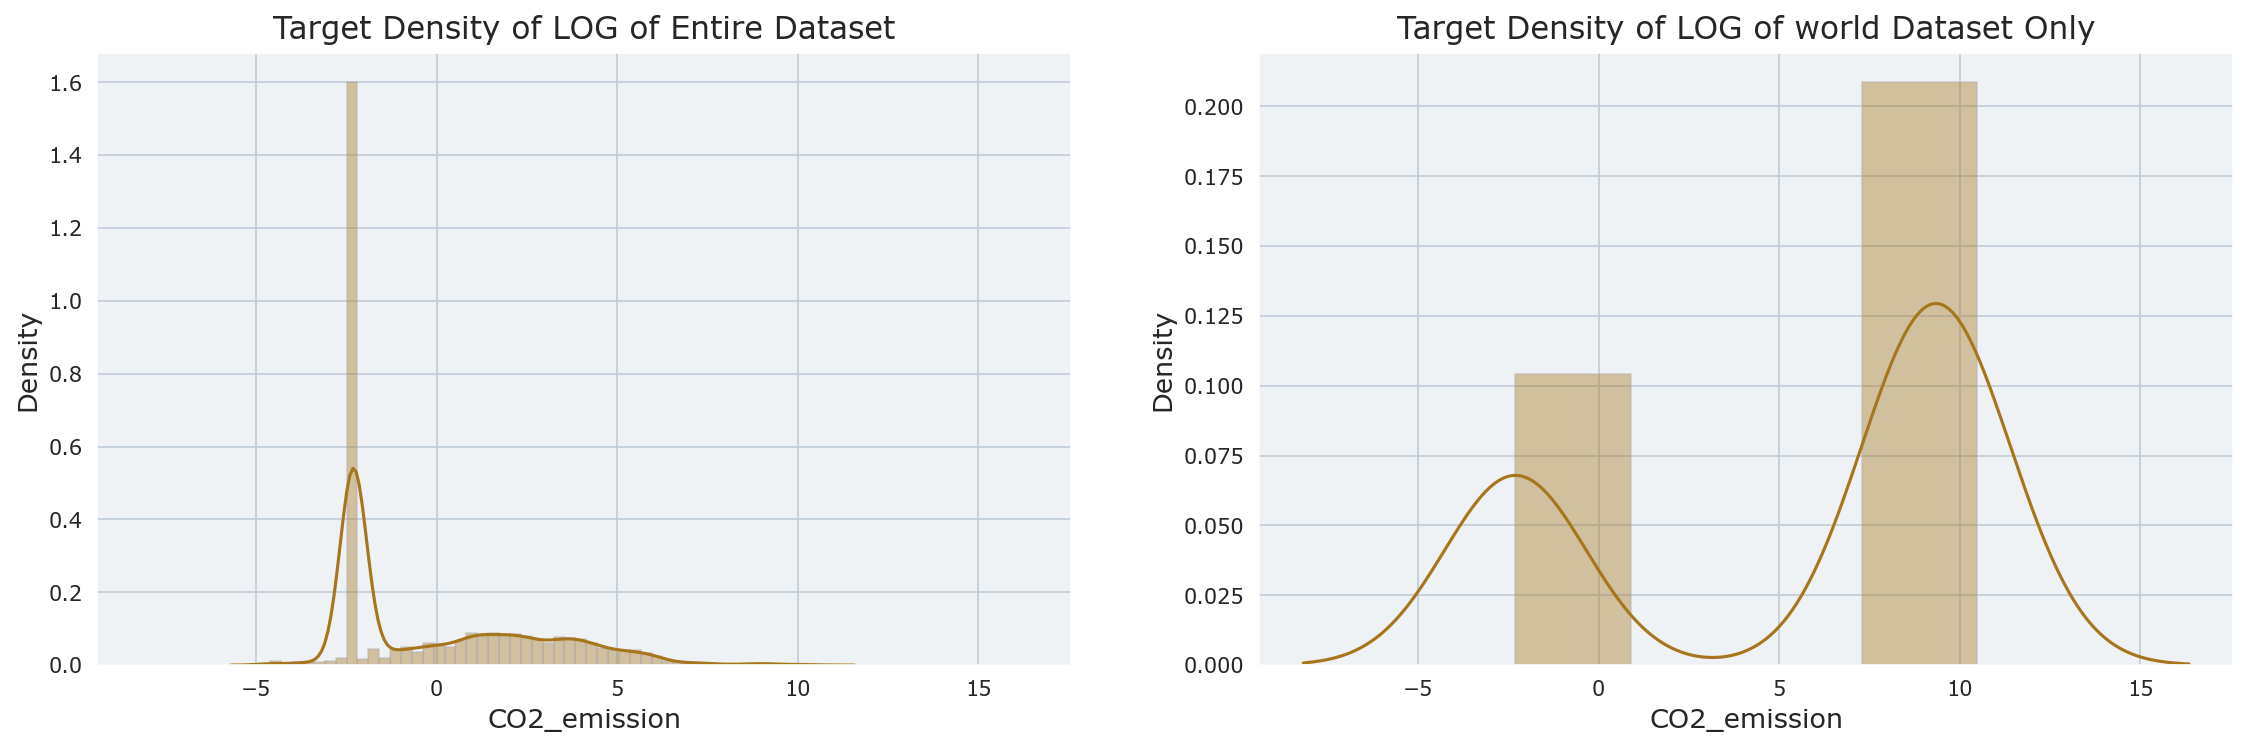

In [50]:
'''
Plotting of distribution of our the LOG of our Target data
'''
with plt.rc_context(rc = {'figure.dpi': 150, 'axes.labelsize': 13,
                          'xtick.labelsize': 10, 'ytick.labelsize': 10,
                          'legend.title_fontsize': 7, 'axes.titlesize': 15,
                          'axes.titlepad': 7}):


    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,5))
    
    # Entire dataset
    sns.distplot(lf['CO2_emission'], ax=ax[0]).set_title('Target Density of LOG of Entire Dataset')
    
    # Dataset only for world
    world = lf[lf['Country']=='World']
    sns.distplot(world['CO2_emission'], ax=ax[1]).set_title('Target Density of LOG of world Dataset Only')

    plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
    plt.show()

I believe this shows a presence of an outlier... Just a wild guess, 

More work still needs to be done here... but for now, let's proceed with our base analysis

### Distribution of energy types

In [16]:
temp_dist = df.groupby('e_type').count()['CO2_emission'].reset_index().sort_values(by='CO2_emission',ascending=False)
temp_dist.style.background_gradient(cmap='winter')

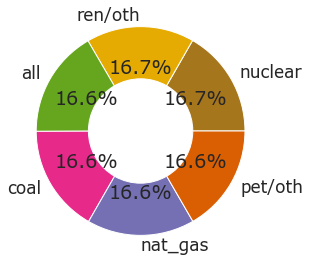

In [17]:
percent = temp_dist['CO2_emission']
labels= temp_dist['e_type']

my_pie,_,_ = plt.pie(percent, radius = 1.2, labels=labels, autopct="%.1f%%")
plt.setp(my_pie, width=0.6, edgecolor='white') 
plt.show()

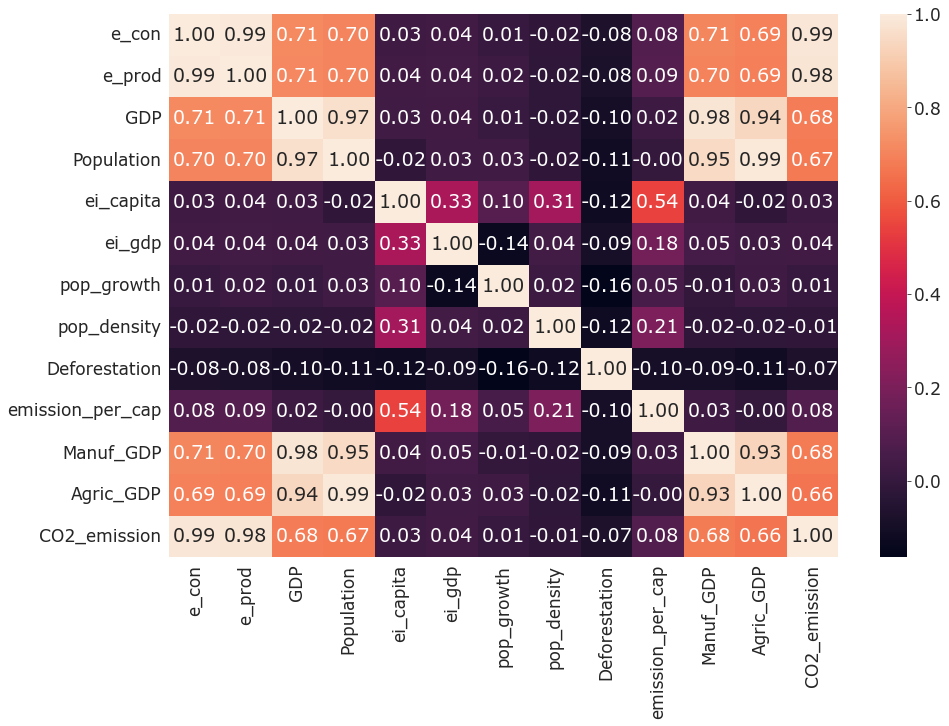

In [18]:
# Visuals of Correlation Heatmap between Features
plt.figure(figsize=(15,10))
sns.heatmap(data=df.iloc[:,3:].corr(), annot=True, fmt='.2f')
plt.show()

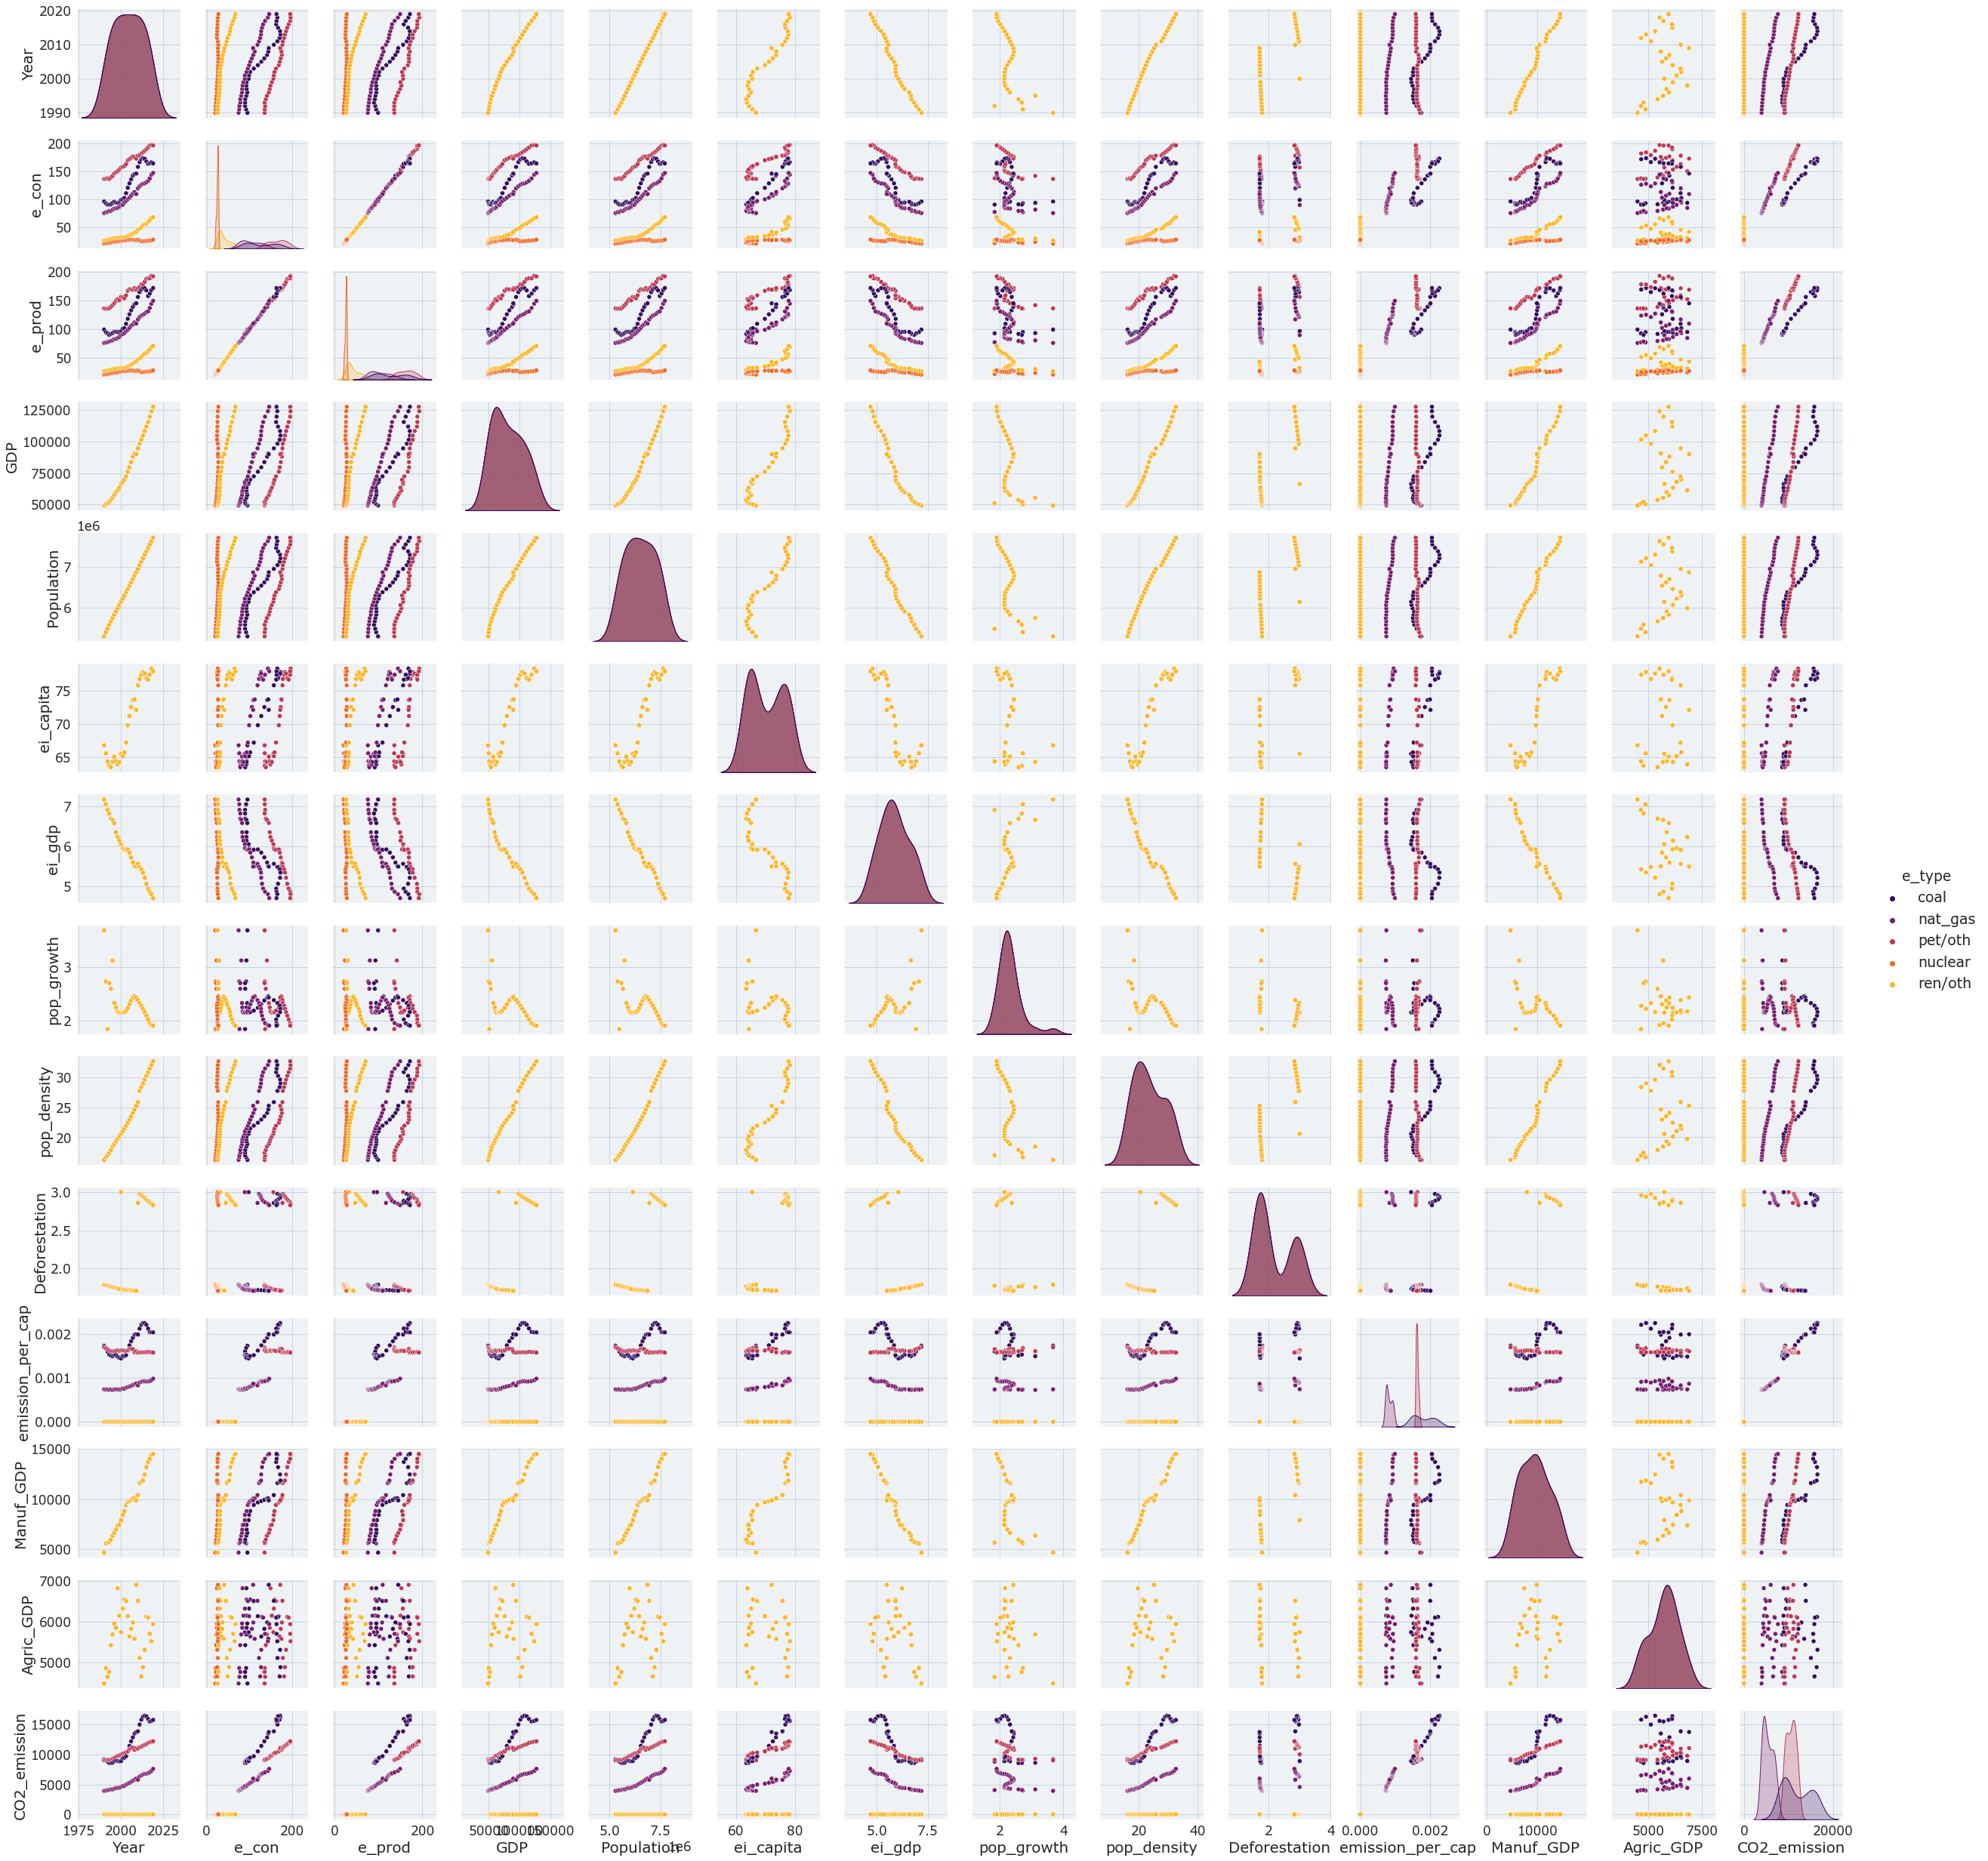

In [19]:
# Let's Get a Pair Plot for the world & for ALL Energy Type Category
temp_pp = df[df['Country']=='World'][df['e_type']!='all']

sns.pairplot(temp_pp, hue='e_type', palette="inferno")
plt.show()

### COMPARING: 
**`Who produced the most CO2 Emissions over this time period?` vs `CO2 Emissions per Capita per Country over this time period`**

In [20]:
# Making temp dataset of all countries and there total CO2 emissions in the time period

# Specifying all countries != world, as well energy_types=all 
cd1 = df[df['Country']!='World'][df['e_type']=='all']

lt = []
for country in cd1['Country'].unique():
    total = cd1[cd1['Country']==country]['CO2_emission'].sum(axis=0)
    lt.extend([[country, total]])
lts = []
for country in cd1['Country'].unique():
    total = cd1[cd1['Country']==country]['emission_per_cap'].sum(axis=0)
    lts.extend([[country, total]])
    
# Temporary dataset of all the Countries and there respective total CO2 Emission over the time period
temp_cd = pd.DataFrame(lt, columns=['Country', 'Total_CO2']).sort_values(by='Total_CO2',ascending=False)
# Temporary dataset of all the Countries and there respective total emission_per_capita over the time period
temp_cd2 = pd.DataFrame(lts, columns=['Country', 'emission_per_cap']).sort_values(by='emission_per_cap',ascending=False)

# Plotting the top 20 Emiters
fig = px.bar(temp_cd.head(20), x='Country', y='Total_CO2', title='Top 20 CO2 Emitters (MMtonnes CO2)')
# Plotting the top 20 emission_per_capita
fig2 = px.bar(temp_cd2.head(20), x='Country', y='emission_per_cap', 
              title='Top 20 Countries with emission_per_capita (MMtonnes CO2 per Pop)')
fig.show(), fig2.show()

(None, None)

In [21]:
'''
Let's Visualise the comparison using a line graph
'''
temp_td = temp_cd.copy()
# Create a df containing ranked countries, Total_C02 & emission_per_cap
temp_td = pd.merge(temp_td, temp_cd2, how="left", on='Country')
# Seperate country because it's an Object variable
others = temp_td.drop(['Country'], axis=1)
c = temp_td['Country']
# Scale the features to be compared to deal with Range Variation
sc = StandardScaler()
others_scaled = pd.DataFrame(sc.fit_transform(others), columns=others.columns)
# concat both Tables 
temp_td_scaled = pd.concat([c, others_scaled], axis=1)
# Plot Multiple line graph
fig4 = px.line(temp_td_scaled.head(30), x='Country', y=['Total_CO2', 'emission_per_cap'], title='Top 20 CO2 Emitters vs Top emitters_per_Capita')
fig4.show()

From Wiki:

* The UAE economy is heavily reliant on revenues from petroleum and natural gas
* The economy of Singapore is a highly developed free-market economy (an economy in which all resources are owned by individuals), Hence High Transportation, Heat & Electrical energy demand of which it's major sources are Petroleum Fuels 
* Petroleum and natural gas are the cornerstones of Qatar's economy and account for more than 70% of total government revenue, more than 60% of gross domestic product, and roughly 85% of export earnings.
* The economy of Kuwait is a wealthy petroleum-based economy

<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/OPEC_oil_exports.png" width=50%/> 

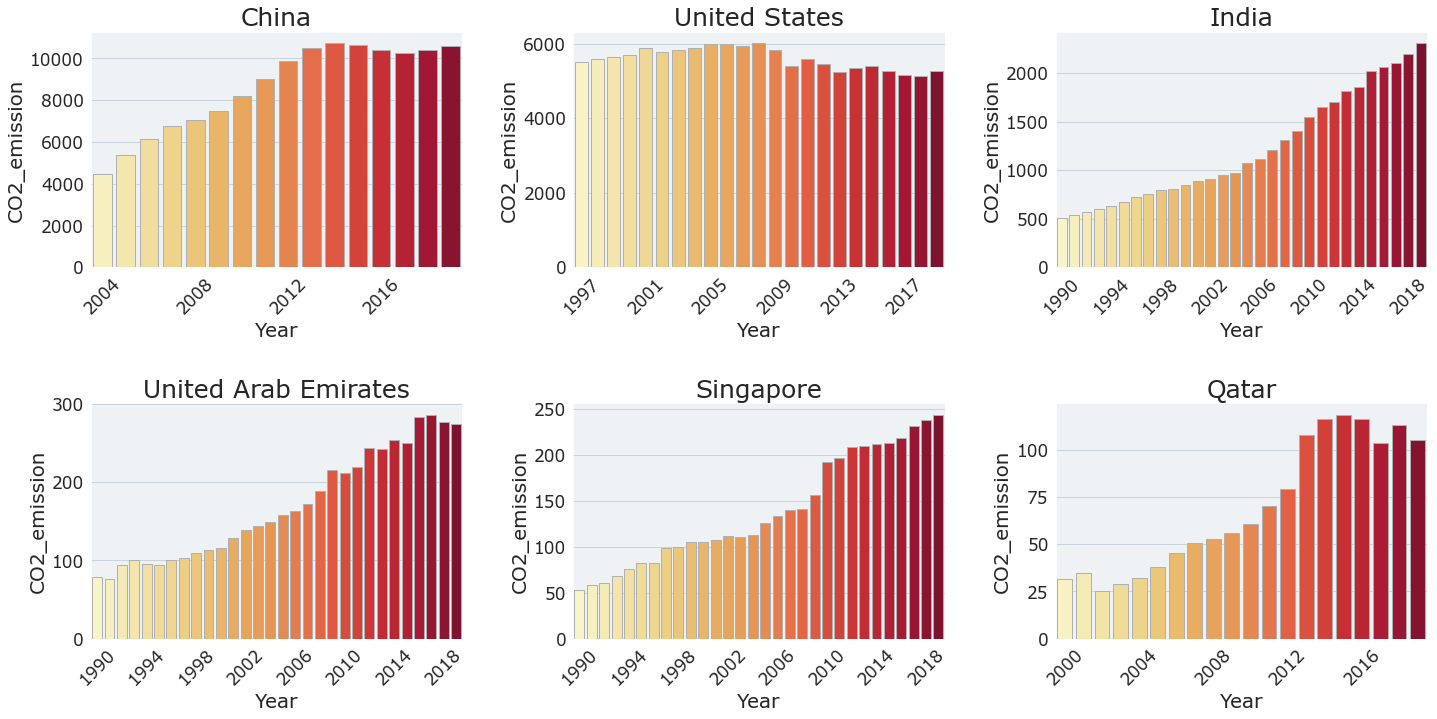

In [22]:
'''
Let's Visualise the actual CO2 Emission 
of Our Top 3 Emitting Countries & 
Our Top emitting_per_capita Countries
'''

fig, ax = plt.subplots(2, 3, figsize = (20, 10))

# List of focused Countries
countries = ['China','United States', 'India', 
             'United Arab Emirates', 'Singapore', 'Qatar' ]

    
# Average CO2 Emission each year for top 6 emiters
for idx, (country, axes) in enumerate(zip(countries, ax.flatten())):
        
    cd3 = df[df['Country']==country][df['e_type']=='all']
    temp_data = cd3.groupby(['Year'])['CO2_emission'].sum().reset_index().sort_values(by='CO2_emission',ascending=False)
    plot_ = sns.barplot(ax=axes, data=temp_data, x='Year', y='CO2_emission', palette="YlOrRd")
    
    # Title
    axes.set_title(country)
    
    # Reducing Density of X-ticks
    for ind, label in enumerate(plot_.get_xticklabels()):
        if ind % 4 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    
    # Rotating X axis
    for tick in axes.get_xticklabels():
        tick.set_rotation(45)
    
    
### Removing empty figures
else:
    [axes.set_visible(False) for axes in ax.flatten()[idx + 1:]]
    
    
plt.tight_layout(pad=0.4, w_pad=2, h_pad=2)
plt.show()

## Comparing Time Series Btw Top Emitting Country & Top Emitting_per_Capita Country

In [23]:
'''
Time Series for Top Emitting Country
Country: China
'''
c_df = df[df['Country']== 'China'][['Year', 'e_type','GDP', 'Population',
                                    'e_con', 'Deforestation', 'emission_per_cap', 'CO2_emission']]
c_df = c_df[c_df['e_type']== 'all'].drop('e_type', axis=1)
# Seperate country because it's an Object variable
ot = c_df.drop(['Year'], axis=1)
c = c_df['Year'].to_list()
# Scale the features to be compared to deal with Range Variation
sc = StandardScaler()
ot_s= pd.DataFrame(sc.fit_transform(ot), columns=ot.columns)
# Join Tables
china_comp = ot_s.copy()
china_comp['Year'] = c
# Plot Multiple line graph
fig5 = px.line(china_comp, x='Year', y=['emission_per_cap', 'CO2_emission', 
                                        'GDP', 'Population', 'Deforestation'], 
               title='Time Series for our Top Emitting Country = CHINA')

fig5.show()

China clearly is not doing well in terms of adpoting greener policies in times past, as we can see that her CO2 emission per capita is racing side-by-side with her actual CO2 Emission and GDP Growth. These was much terrible between 2012-2015, but as we can see China's Economic Strategy in 2016, had the Chinese leaders vowing to confront the overcapacity problem as part of supply-side reforms. Understand, Overcapcity & Population raise may sound similar but doesn't eitherly mean the same thing. This move as you can see, is one of the decisions that lead to the quick switch to better lesser co2 emitting processes even with a continous raise in GDP, Population and Deforestation.

In [24]:
'''
Time Series for Top Emitting_per_Capita Country
Country: UAE (United Arab Emirates)
'''
u_df = df[df['Country']== 'United Arab Emirates'][['Year', 'e_type','GDP', 'Population',
                                    'e_con', 'Deforestation', 'emission_per_cap', 'CO2_emission']]
u_df = u_df[u_df['e_type']=='all'].drop('e_type', axis=1)
# Seperate country because it's an Object variable
ot = u_df.drop(['Year'], axis=1)
c = u_df['Year'].to_list()
# Scale the features to be compared to deal with Range Variation
sc = StandardScaler()
ot_s= pd.DataFrame(sc.fit_transform(ot), columns=ot.columns)
# Join Tables
UAE_comp = ot_s.copy()
UAE_comp['Year'] = c
# Plot Multiple line graph
fig6 = px.line(UAE_comp, x='Year', y=['emission_per_cap', 'CO2_emission', 
                                        'GDP', 'Population', 'Deforestation'], 
               title='Time Series for our Top Emitting_per_Capita Country (UAE)')

fig6.show()

The UAE has remained Busy with her manufacturing sector and of course as a leading country in terms of Petroleum production, and also being the one of the tourist center of the world, it's only normal for we to see the high peak in CO2_emission_per_capita comming from here; But she has got two very good signs;

1. She has greatly matched reducing the CO2_emission_per_capita even with her every increasing activities, from policies to embracing Technology
2. She has flatten the Deforestation quick raise, proving her committment towards a more greener world.

In [27]:
'''
Comparing Total GDP, Manuf_GDP, & Agric_GDP
Country: WORLD
'''
g_df = df[df['Country']== 'United Arab Emirates'][['Year', 'e_type','GDP', 'Manuf_GDP',
                                    'Agric_GDP', 'emission_per_cap', 'CO2_emission']]
g_df = g_df[g_df['e_type']=='all'].drop('e_type', axis=1)
# Seperate country because it's an Object variable
ot = g_df.drop(['Year'], axis=1)
c = g_df['Year'].to_list()
# Scale the features to be compared to deal with Range Variation
sc = StandardScaler()
ot_s= pd.DataFrame(sc.fit_transform(ot), columns=ot.columns)
# Join Tables
GDP_comp = ot_s.copy()
GDP_comp['Year'] = c
# Plot Multiple line graph
fig7 = px.line(GDP_comp, x='Year', y=['emission_per_cap', 'CO2_emission', 
                                        'GDP', 'Manuf_GDP', 'Agric_GDP'], 
               title='WORLD Comparison of Total GDP, Manuf_GDP, & Agric_GD')

fig7.show()

Remember the Global Economic Recession 2007-2009???

The global financial crisis (GFC) which refers to the period the world experienced extreme stress in global financial markets and banking systems, occurred between mid-2007 and early 2009. This as we can see has been clearly captured by this dataset. If not for this event, it was an upward trajectory in terms of World GDP and CO2 emissions with the Manufacturing Industry (Purple Line), which is the sector of GDP that sustained its trajectory resulting in the corresponding rise in CO2 Emissions.

Simply put: `Manufacturing GDP Contribution is the primary GDP factor that correlates the direct rise in GDP to CO2 emission.`

Also; It's worthy of mentioning that we can see a stip decline in Co2 emission per capita even with the raise in ManuFacturing GDP & CO2 emission; This shows that the world is actually taking a good turn towards lesser CO2 Emissions by adopting safer manufacturing technologies and processes. In Fact, This shows, that while we are gradually migrating to more greener energy sources, we will be seeing a much decline in CO2 Emissions.

It's also great news to see that the Agricultural sector is picking up again globally.